# Investigate simulations with shared soil column per pft, for whole grid cell

Inne Vanderkelen - October 2023

## 1. Settings

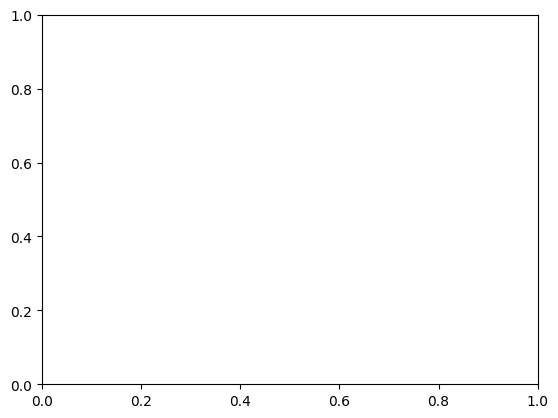

In [3]:
# laod modules 
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import regionmask 
import dask.array as daskarray
from dask.distributed import Client

# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import * #info on ctsm utils: https://github .com/NCAR/ctsm_python_gallery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [4]:
# directory settings

# set directories
outdir = '/scratch/snx3000/ivanderk/'

# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

In [5]:
# case settings

# define scenario
scenario = '4p1000'

# case settings
case_ctl = 'I2000Clm51Sp.hcru_hcru_mt13.CTL'
case_scen = 'I2000Clm51Sp.hcru_hcru_mt13.'+scenario

case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.CTL.spunup'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.'+scenario+'.spunup'

case   = case_ctl
block  = 'lnd' 
stream = 'h2' 

# List of variables to import from file(s) in $indir matching $pattern.
variables = ['QDRAI', 'QINFL', 'QOVER', 'TOTSOILLIQ', 'EFLX_LH_TOT', "QVEGE", "QVEGT","QSOIL", 'QIRRIG_FROM_SURFACE']

# discard 2004 until 2008 as spin up years
start_year, end_year = 1991, 2014 # 2028 

time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-31")

In [6]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='60GB')
client

<Client: 'tcp://127.0.0.1:35151' processes=2 threads=4, memory=111.76 GiB>

## 2. Load data

### Load simulations

In [68]:
# load sample control file to get the right longnames and units
ds_sample = import_case(case_ctl, myVars=variables, stream='h0', timeSlice=slice(str(start_year)+"-01-01", str(start_year)+"-02-01"))

In [113]:
variables = ['QDRAI', 'QINFL', 'QOVER', 'TOTSOILLIQ', 'EFLX_LH_TOT', "QVEGE", "QVEGT","QSOIL", 'QIRRIG_FROM_SURFACE']

ds_ctl = load_ds_drydays_ymean(variables, case_ctl, stream, start_year, end_year)
ds_scen = load_ds_drydays_ymean(variables, case_scen, stream, start_year, end_year)

for variable in variables: 
    ds_scen[variable].attrs['units'] = ds_sample[variable].units
    ds_ctl[variable].attrs['units'] = ds_sample[variable].units

ds_ctl_new = conv_hydrol_var(ds_ctl, variables)
ds_scen_new = conv_hydrol_var(ds_scen, variables)

ds_delta = ds_scen - ds_ctl

for variable in variables: 
    ds_delta[variable].attrs['long_name'] = ds_sample[variable].long_name
    ds_ctl[variable].attrs['long_name'] = ds_sample[variable].long_name


### Load auxiliary data (soil levels, input dataset, wilting point etc) 

In [48]:
# input data
# define variables to load from input dataset
input_variables = ['ORGANIC','PFTDATA_MASK','PCT_SAND','PCT_CLAY']

# load inputdata
ds_input, ds_input_scen, landmask = load_inputdata(scenario, input_variables, case_ctl)

In [49]:
# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()


In [13]:
# get masks for sandy and clay soils

# define tresholds for pct sand and pct clay
pct_sand_threshold_min = 50
pct_sand_threshold_max = 85
pct_clay_threshold = 40
da_sand_mask, da_clay_mask = get_texture_masks(pct_sand_threshold_max,pct_sand_threshold_min,  pct_clay_threshold, ds_input, levsoi_thickness)



In [14]:
# wilting point
# load precalculated wilting point datasets
da_wilting_h2osoi, da_wilting_h2osoi_scen = load_wilting_h2osoi(scenario) 

### Plotting settings

In [15]:
## settings

# get mask and region ids
exclude_ids = np.array([0,1,2,16,28,29,30,31])
mask = regionmask.defined_regions.ar6.land.mask(ds_ctl['QDRAI'])

region_ids = np.arange(0,44)
region_ids = np.delete(region_ids, exclude_ids)

plotting_depth = 2 # m 8
figsize = (17,38)


## 3. Analysis & plotting

### Absolute values

QIRRIG_FROM_SURFACE not in limits


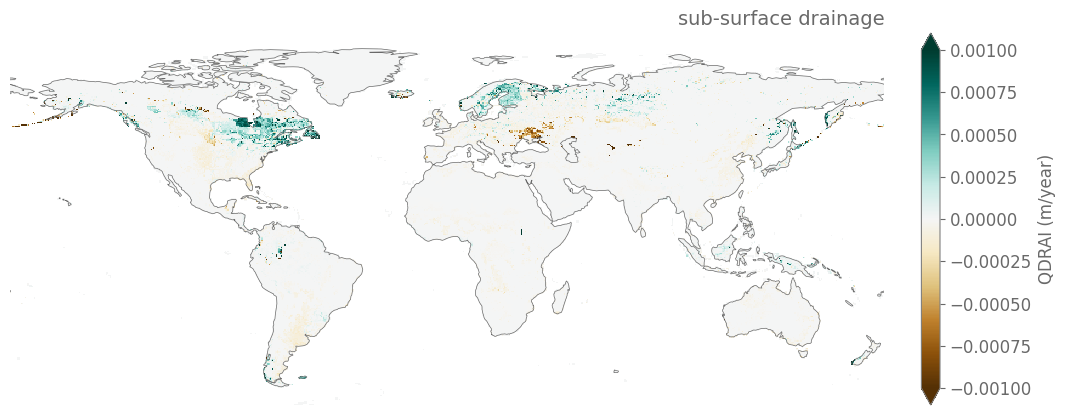

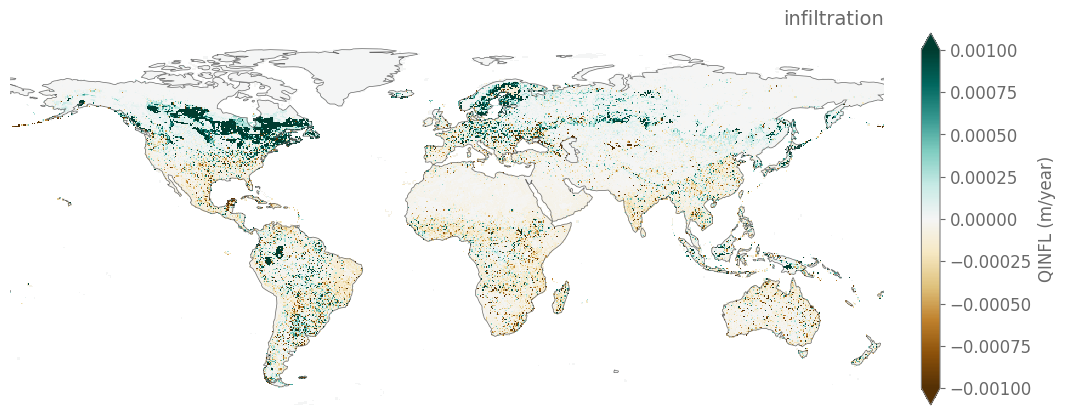

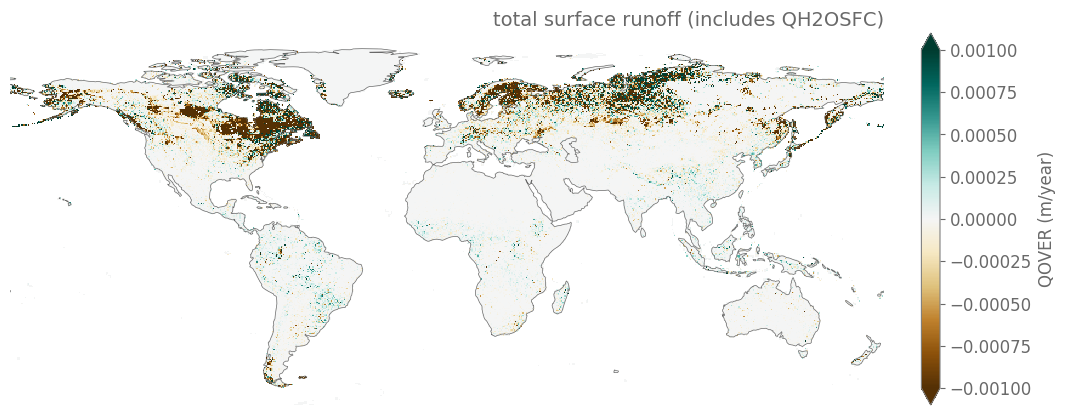

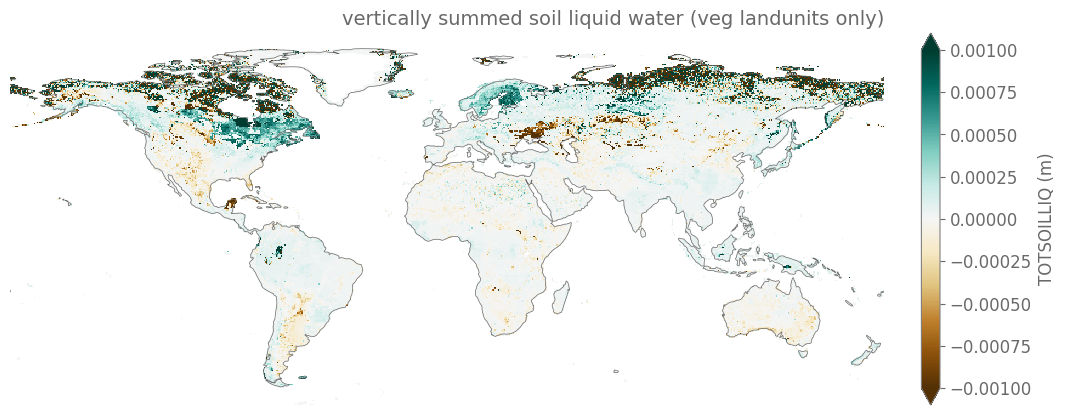

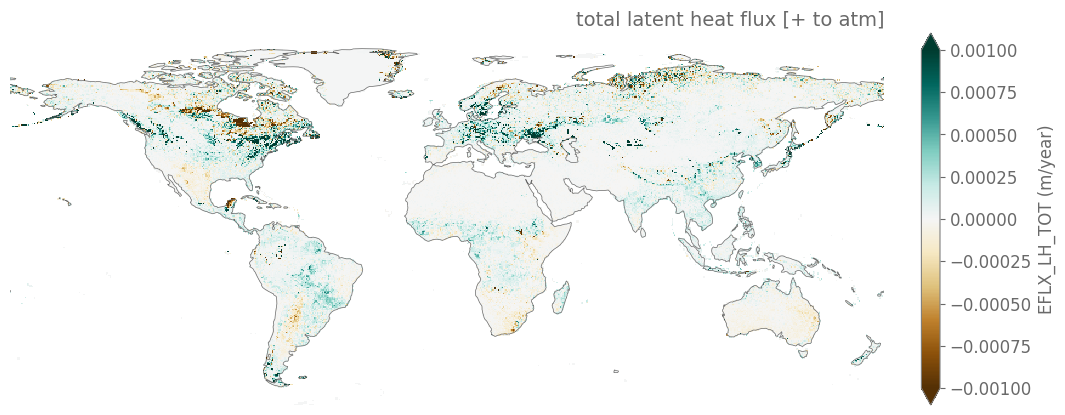

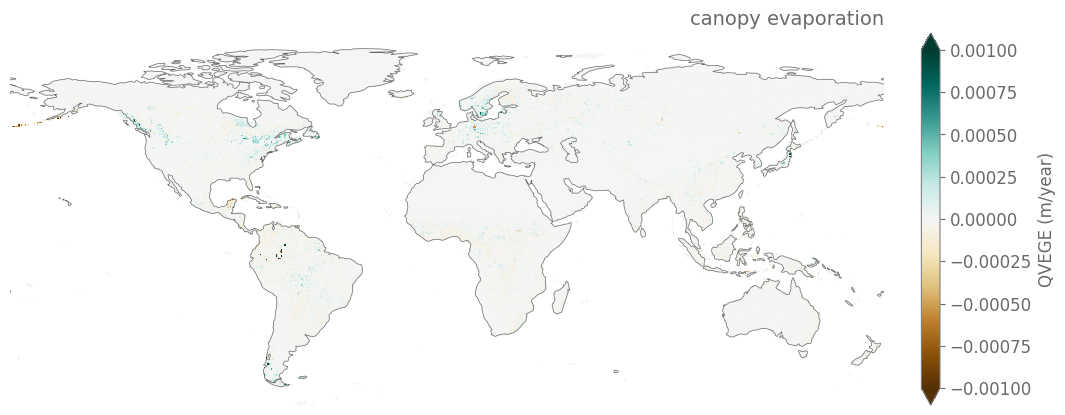

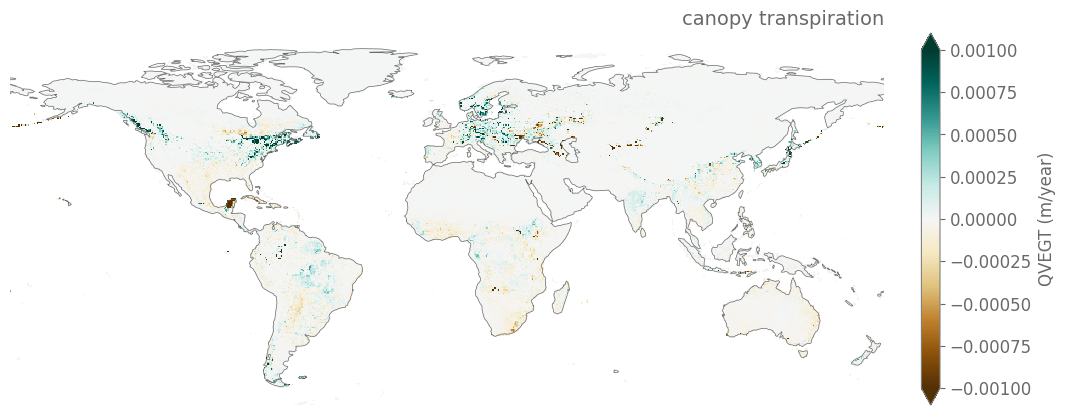

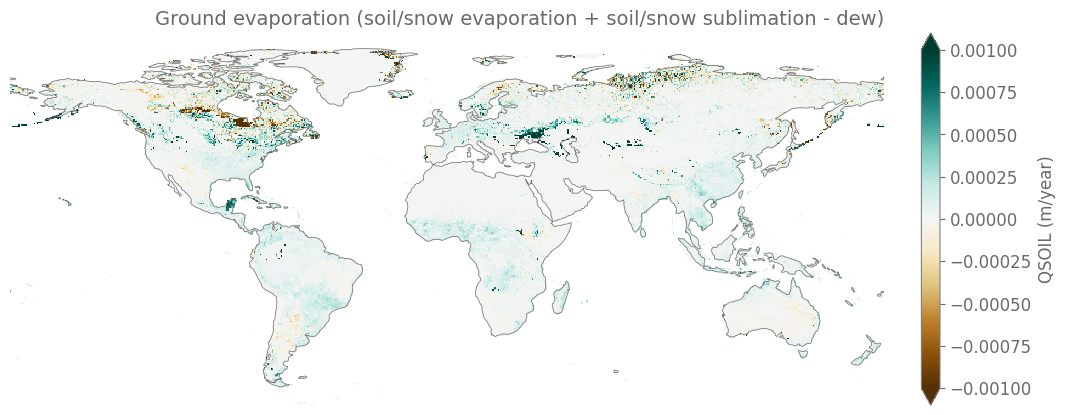

In [128]:
# difference 

d_vlims = { "QDRAI"         : [-1e-3,1e-3], 
           "QINFL"         : [-1e-3,1e-3],
           "QOVER"         : [-1e-3,1e-3],
           "TOTSOILLIQ"    : [-1e-3,1e-3],
           "SOILWATER_10CM": [-4,4],
           "EFLX_LH_TOT"         : [-1e-3,1e-3],
           "QVEGT"         : [-1e-3,1e-3], 
           "QVEGE"         : [-1e-3,1e-3], 
           "QSOIL"         : [-1e-3,1e-3]}


for i, variable in enumerate(variables): 
    calc_plot_delta(ds_delta, ds_ctl, variable, d_vlims)

In [ ]:
d_vlims = { "QDRAI"         : [-1e-7,1e-7], 
           "QINFL"         : [-1e-5,1e-5],
           "QOVER"         : [-1e-7,1e-7],
           "TOTSOILLIQ"    : [-20,20],
           "TOTSOILICE"    :  [-20,20], 
           "SOILWATER_10CM": [-4,4],
           "TWS"           : [-8,8],
           "ZWT"           : [-0.005,0.005], 
           "QINFL"         : [-1e-5,1e-5],
           "EFLX_LH_TOT"         : [-0.5,0.5],
           "SOILLIQ"         : [-0.5,0.5],
           "SOILICE"         : [-0.5,0.5],
           "QVEGT"         : [-1e-7,1e-7], 
           "QVEGE"         : [-1e-8,1e-8], 
           "QSOIL"         : [-1e-7,1e-7], 
           "watfc"         : [-0.0002,0.0002], 
           "watsat"        : [-0.0002,0.0002], 
           "QHR"           : [-2e-7,2e-7], 
           'SMP'           : [-1000,1000],
           'SOILPSI'       : [-0.01,0.01]}


for i, variable in enumerate(variables): 
    calc_plot_delta(ds_delta, ds_ctl, variable, d_vlims)

QIRRIG_FROM_SURFACE not in limits


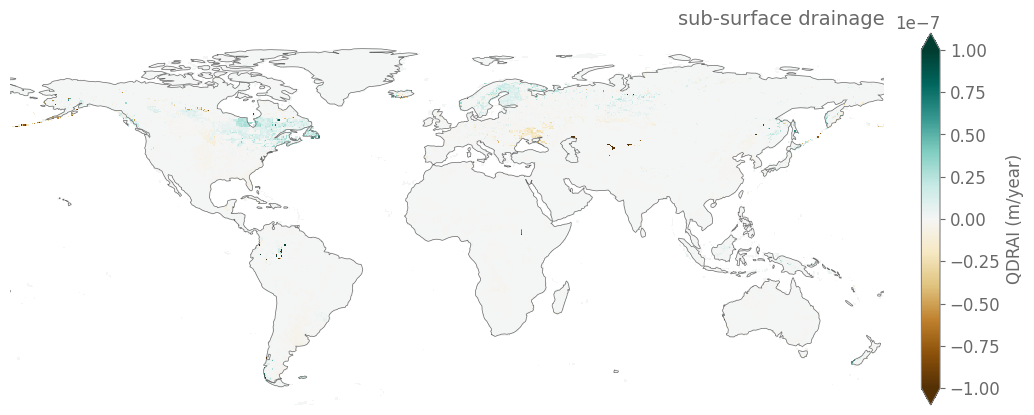

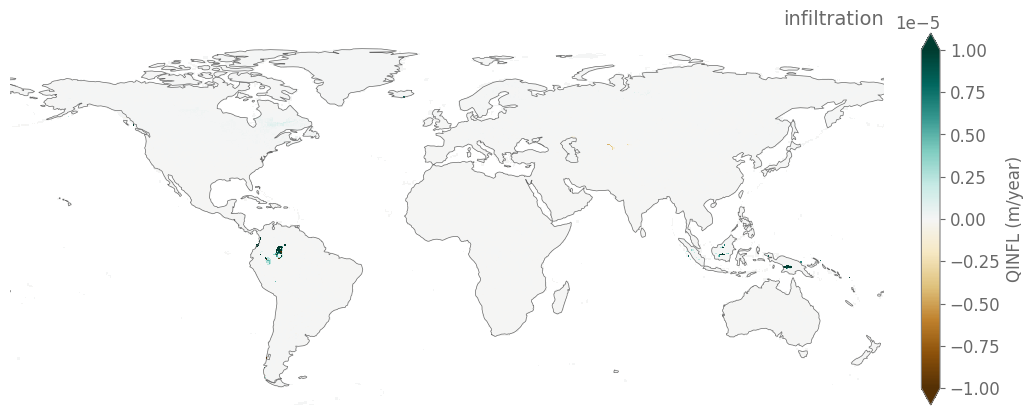

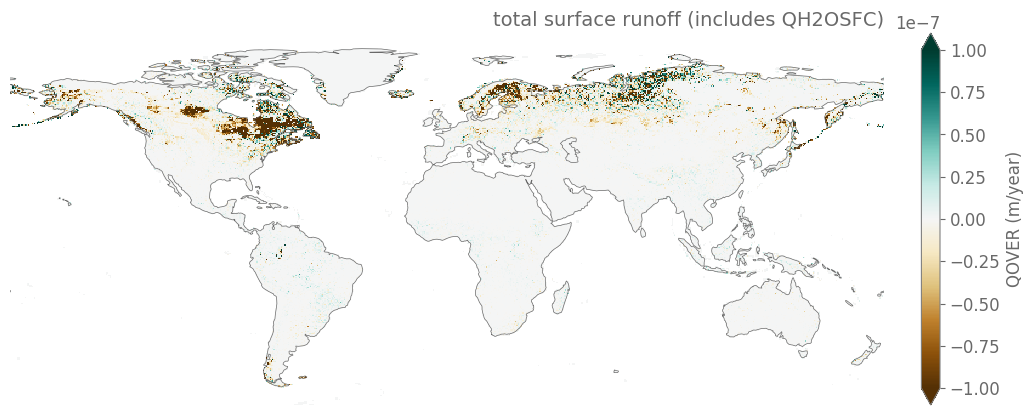

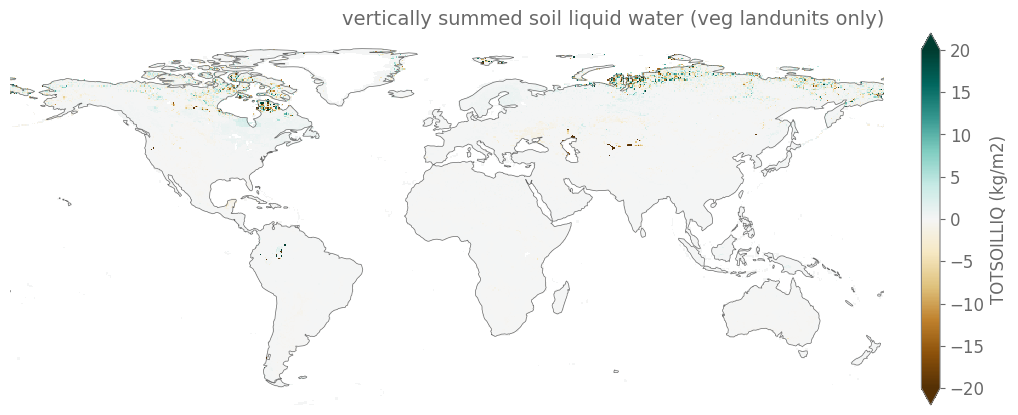

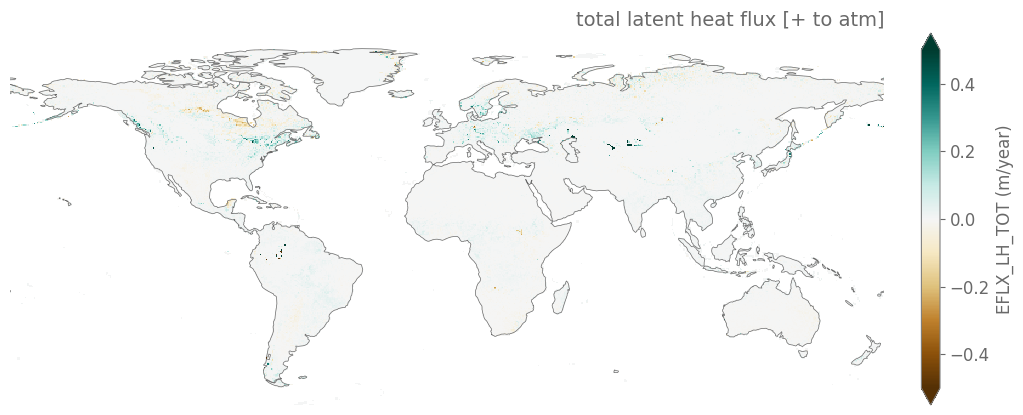

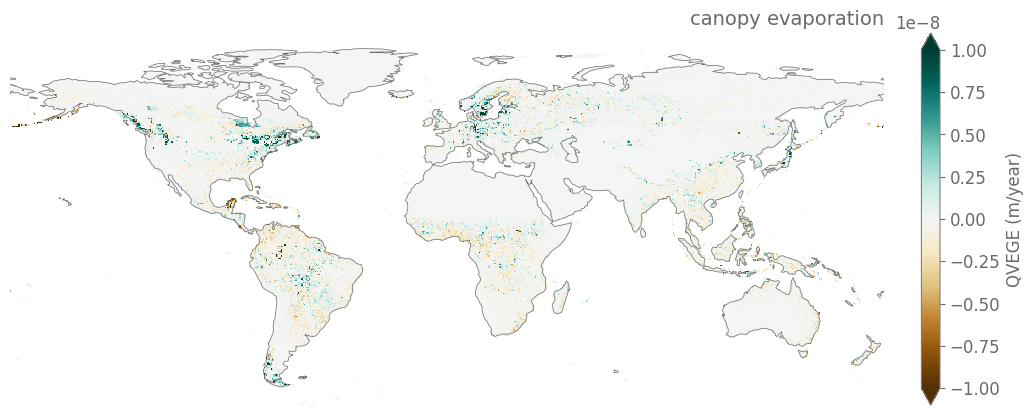

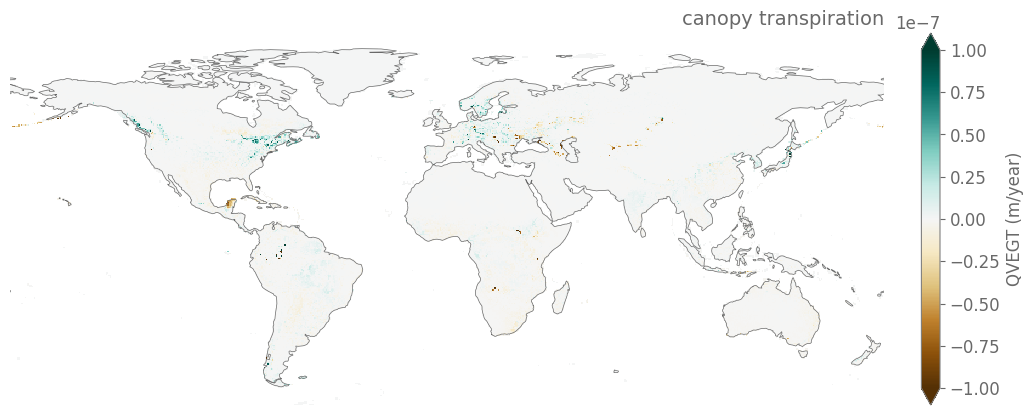

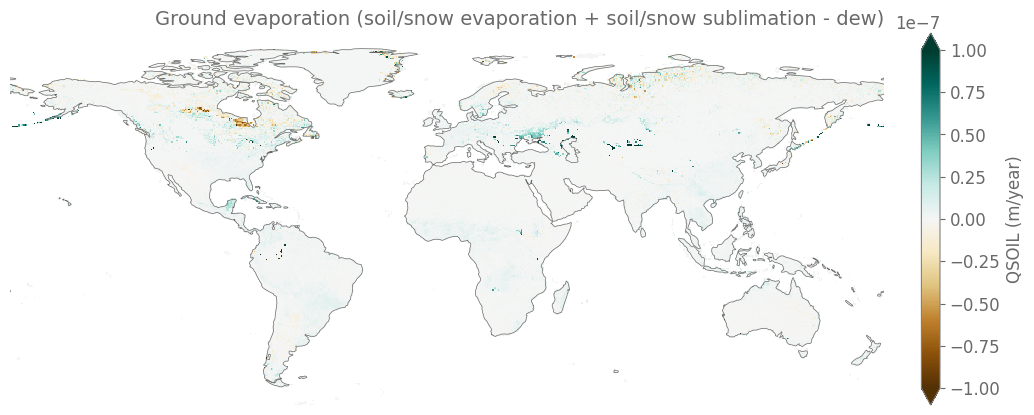

In [59]:
d_vlims = { "QDRAI"         : [-1e-7,1e-7], 
           "QINFL"         : [-1e-5,1e-5],
           "QOVER"         : [-1e-7,1e-7],
           "TOTSOILLIQ"    : [-20,20],
           "TOTSOILICE"    :  [-20,20], 
           "SOILWATER_10CM": [-4,4],
           "TWS"           : [-8,8],
           "ZWT"           : [-0.005,0.005], 
           "QINFL"         : [-1e-5,1e-5],
           "EFLX_LH_TOT"         : [-0.5,0.5],
           "SOILLIQ"         : [-0.5,0.5],
           "SOILICE"         : [-0.5,0.5],
           "QVEGT"         : [-1e-7,1e-7], 
           "QVEGE"         : [-1e-8,1e-8], 
           "QSOIL"         : [-1e-7,1e-7], 
           "watfc"         : [-0.0002,0.0002], 
           "watsat"        : [-0.0002,0.0002], 
           "QHR"           : [-2e-7,2e-7], 
           'SMP'           : [-1000,1000],
           'SOILPSI'       : [-0.01,0.01]}


for i, variable in enumerate(variables): 
    calc_plot_delta(ds_delta, ds_ctl, variable, d_vlims)

### relative differences

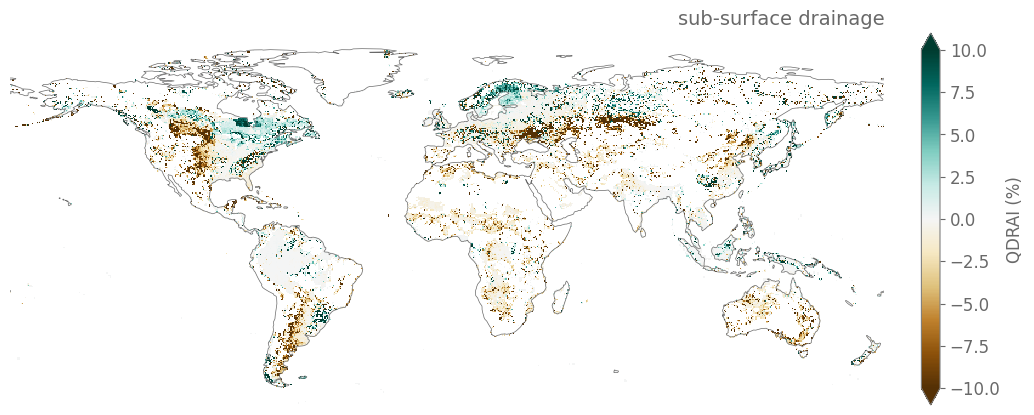

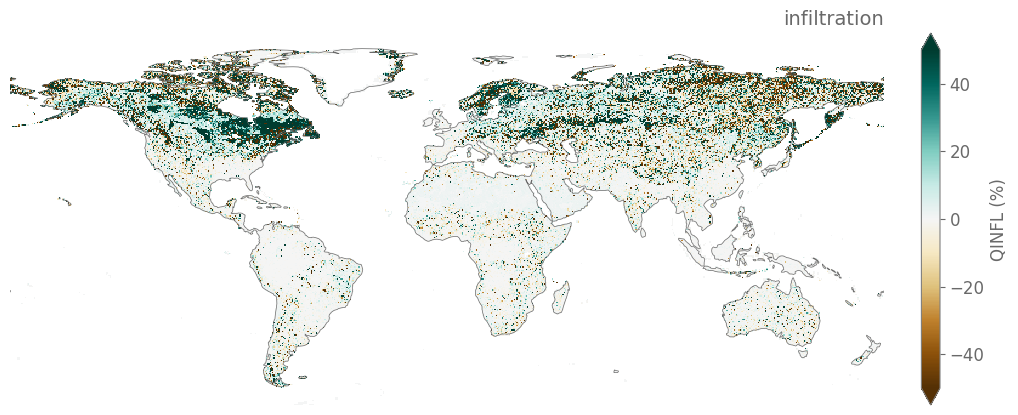

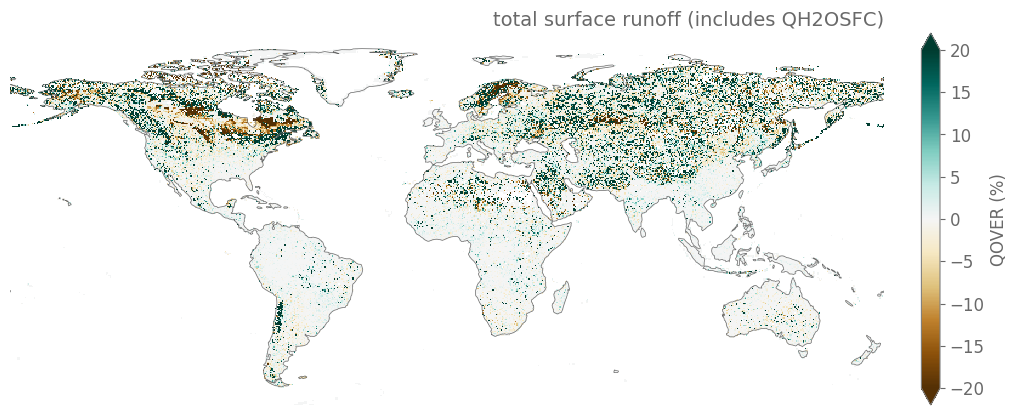

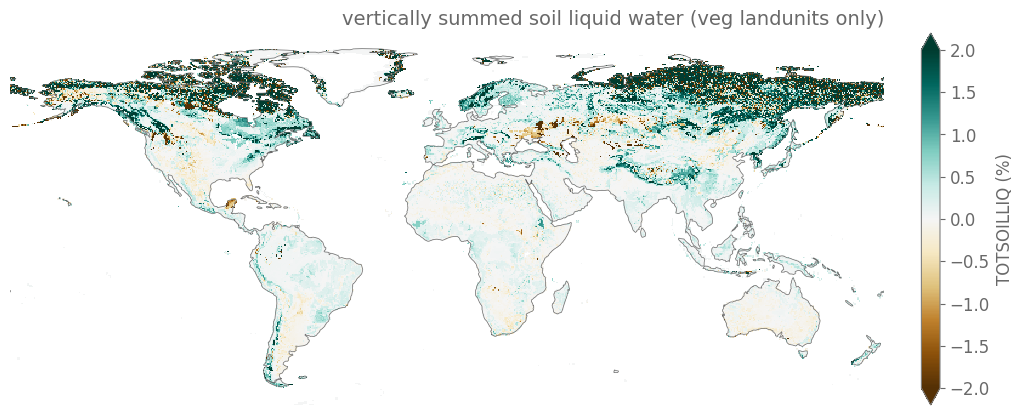

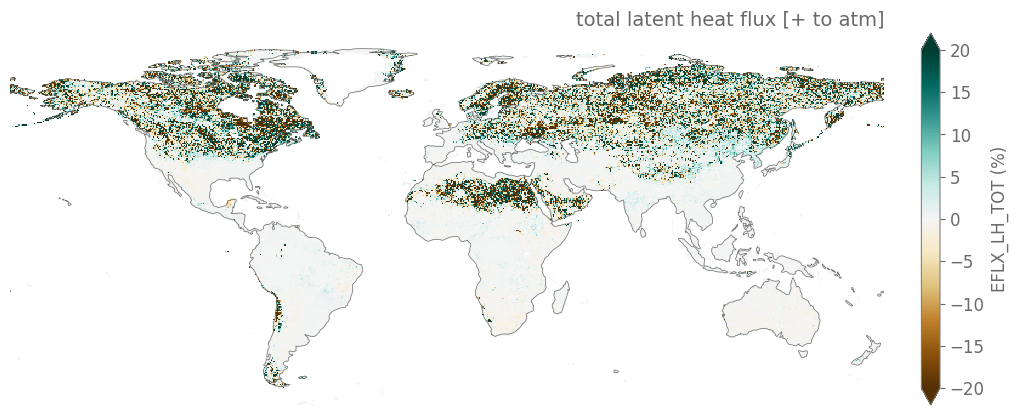

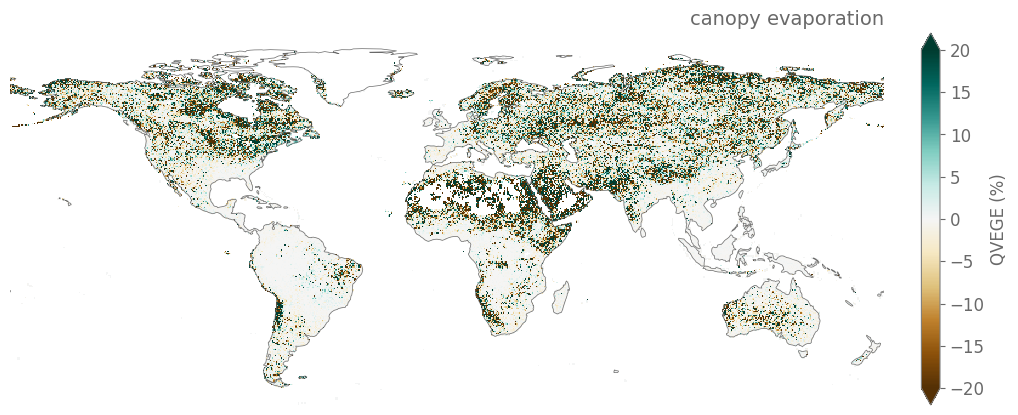

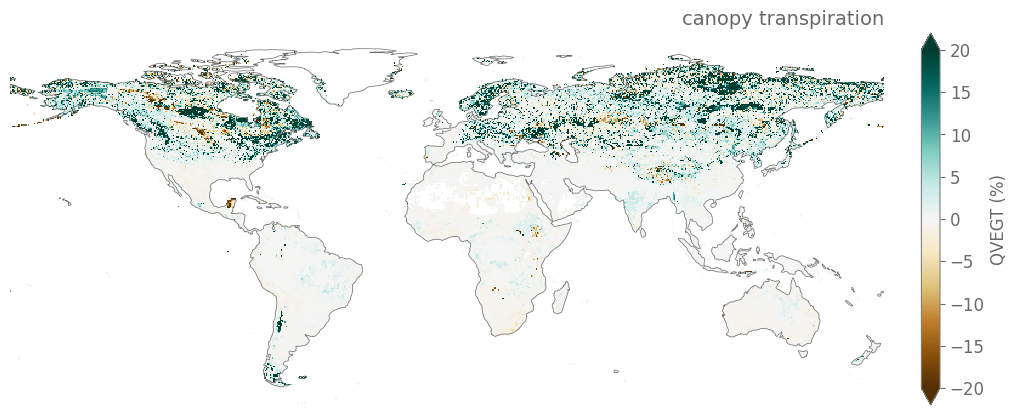

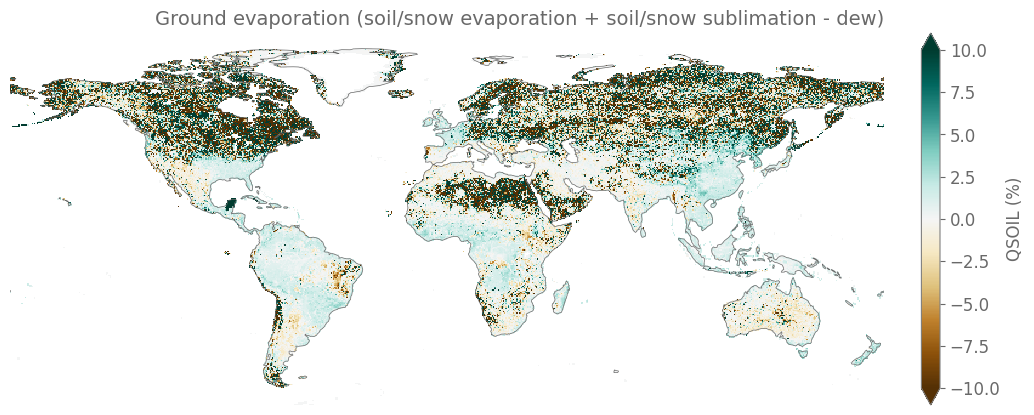

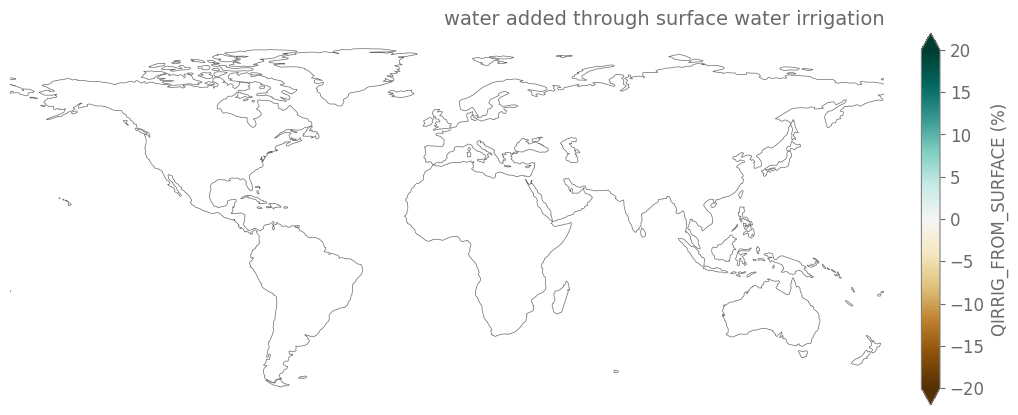

In [51]:
d_vlims = {"QDRAI"         : [-10,10], 
           "QINFL"         : [-50,50], 
           "QOVER"         :  [-20,20], 
           "TOTSOILLIQ"    : [-2,2], 
           "QVEGE"         :  [-20,20], 
           "QVEGT"         :  [-20,20],
           "QSOIL"   :  [-10,10],
           "QIRRIG_FROM_SURFACE"   :  [-20,20],
           "EFLX_LH_TOT"   :  [-20,20],  }


for i, variable in enumerate(variables): 
    calc_plot_delta_rel(ds_delta, ds_ctl, variable, d_vlims)

## Deltas of water balance terms

In [92]:
%%time 


variables_wb = ['TOTSOILLIQ','QDRAI','QOVER','EFLX_LH_TOT', "QVEGE", "QVEGT", 'QSOIL', 'QINFL' ]
variables_wb_toplot = variables_wb

d_wb_vars = {}

ds_delta_timmean = (ds_delta).mean('year') 
ds_ctl_timmean = ds_ctl.mean('year')

for i,region in enumerate(region_ids):

    mask = regionmask.defined_regions.ar6.land.mask(ds_delta['TOTSOILLIQ'])
    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    d_var_list = {}
    for variable,variable_toplot in zip(variables_wb,variables_wb_toplot): 
        da_ctl_seasmean_region = (ds_delta_timmean[variable].where(mask==region).mean(dim=('lat','lon')) / ds_ctl_timmean[variable].where(mask==region).mean(dim=('lat','lon'))).values*100

        d_var_list[variable_toplot]= da_ctl_seasmean_region

    d_wb_vars[str(region)] = pd.Series(d_var_list).to_frame(name=str(region))

df_wbterms = pd.concat([v for k,v in d_wb_vars.items()],axis=1)


CPU times: user 2.91 s, sys: 19.6 ms, total: 2.93 s
Wall time: 2.87 s


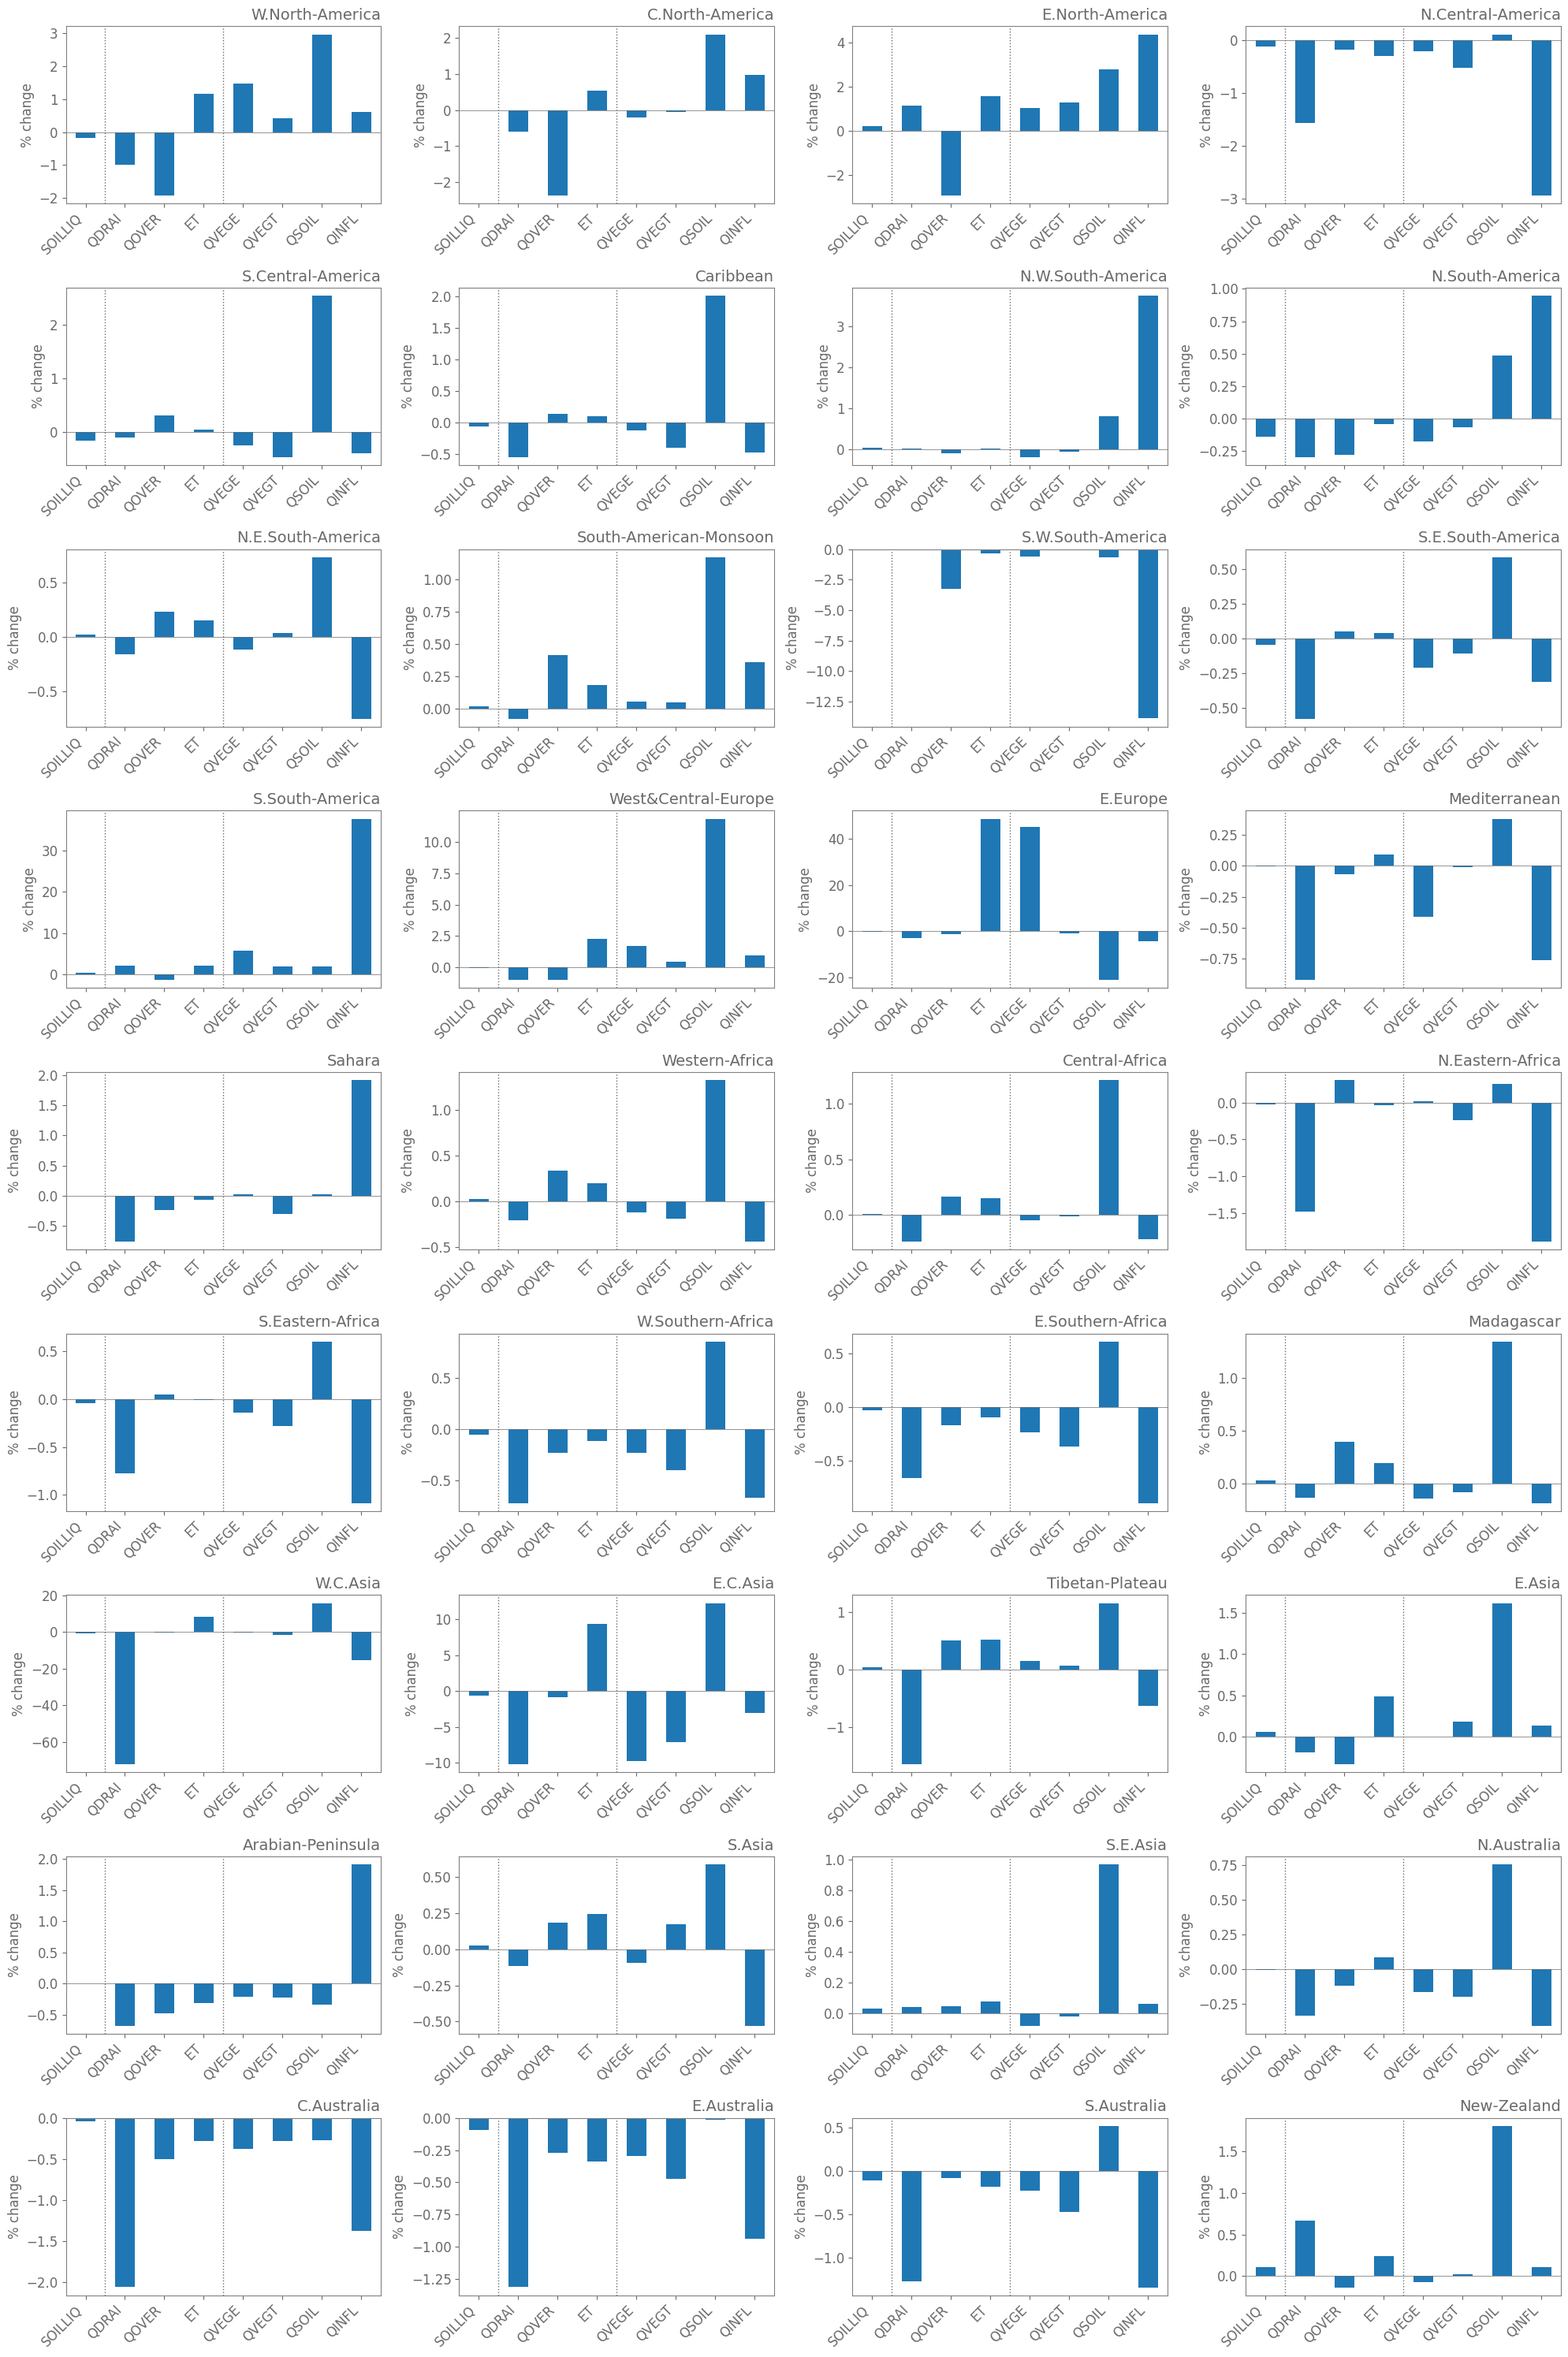

In [93]:
fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

variables_wb = ['TOTSOILLIQ','QDRAI','QOVER','EFLX_LH_TOT', "QVEGE", "QVEGT", 'QSOIL', 'QINFL']
variables_wb_label = ['SOILLIQ','QDRAI', 'QOVER',  'ET', 'QVEGE', 'QVEGT', 'QSOIL', 'QINFL']

variables_wb = list(df_wbterms.index)
x = np.arange(1,len(variables_wb_toplot)+1,1)

for i,region in enumerate(region_ids):
    
    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    ax = axes[i]
    df_wbterms.loc[variables_wb, str(region)].plot.bar(ax=ax, legend=False)
    ax.set_title(region_name,loc='right')
    ax.axhline(y=0, color='dimgray', linewidth=0.5)
    ax.axvline(x=0.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.axvline(x=3.5, color='dimgray', linewidth=1, linestyle = 'dotted')

    ax.set_ylabel('% change')

    ax.set_xticks(range(0,len(df_wbterms.index)),list(variables_wb_label), rotation=45, ha='right')

fig.tight_layout()

## sandy soils

In [20]:
texture_mask = da_sand_mask.compute()
texture_name = texture_mask.name

d_wb_vars = {}

ds_delta_timmean = (ds_delta).mean('year').where(texture_mask)
ds_ctl_timmean = ds_ctl.mean('year').where(texture_mask)

for i,region in enumerate(region_ids):

    mask = regionmask.defined_regions.ar6.land.mask(ds_delta['TOTSOILLIQ'])
    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    d_var_list = {}
    for variable,variable_toplot in zip(variables_wb,variables_wb_toplot): 
        da_ctl_seasmean_region = (ds_delta_timmean[variable].where(mask==region).mean(dim=('lat','lon')) / ds_ctl_timmean[variable].where(mask==region).mean(dim=('lat','lon'))).values*100

        d_var_list[variable_toplot]= da_ctl_seasmean_region

    d_wb_vars[str(region)] = pd.Series(d_var_list).to_frame(name=str(region))

df_wbterms = pd.concat([v for k,v in d_wb_vars.items()],axis=1)
df_wbterms.to_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'.'+texture_name+'_drydays.nc')




NameError: name 'variables_wb' is not defined

## Clay soils

In [95]:
texture_mask = da_clay_mask.compute()
texture_name = texture_mask.name 


d_wb_vars = {}

ds_delta_timmean = (ds_delta).mean('year').where(texture_mask)
ds_ctl_timmean = ds_ctl.mean('year').where(texture_mask)

for i,region in enumerate(region_ids):

    mask = regionmask.defined_regions.ar6.land.mask(ds_delta['TOTSOILLIQ'])
    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    d_var_list = {}
    for variable,variable_toplot in zip(variables_wb,variables_wb_toplot): 
        da_ctl_seasmean_region = (ds_delta_timmean[variable].where(mask==region).mean(dim=('lat','lon')) / ds_ctl_timmean[variable].where(mask==region).mean(dim=('lat','lon'))).values*100

        d_var_list[variable_toplot]= da_ctl_seasmean_region

    d_wb_vars[str(region)] = pd.Series(d_var_list).to_frame(name=str(region))

df_wbterms = pd.concat([v for k,v in d_wb_vars.items()],axis=1)
df_wbterms.to_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'.'+texture_name+'_drydays.nc')


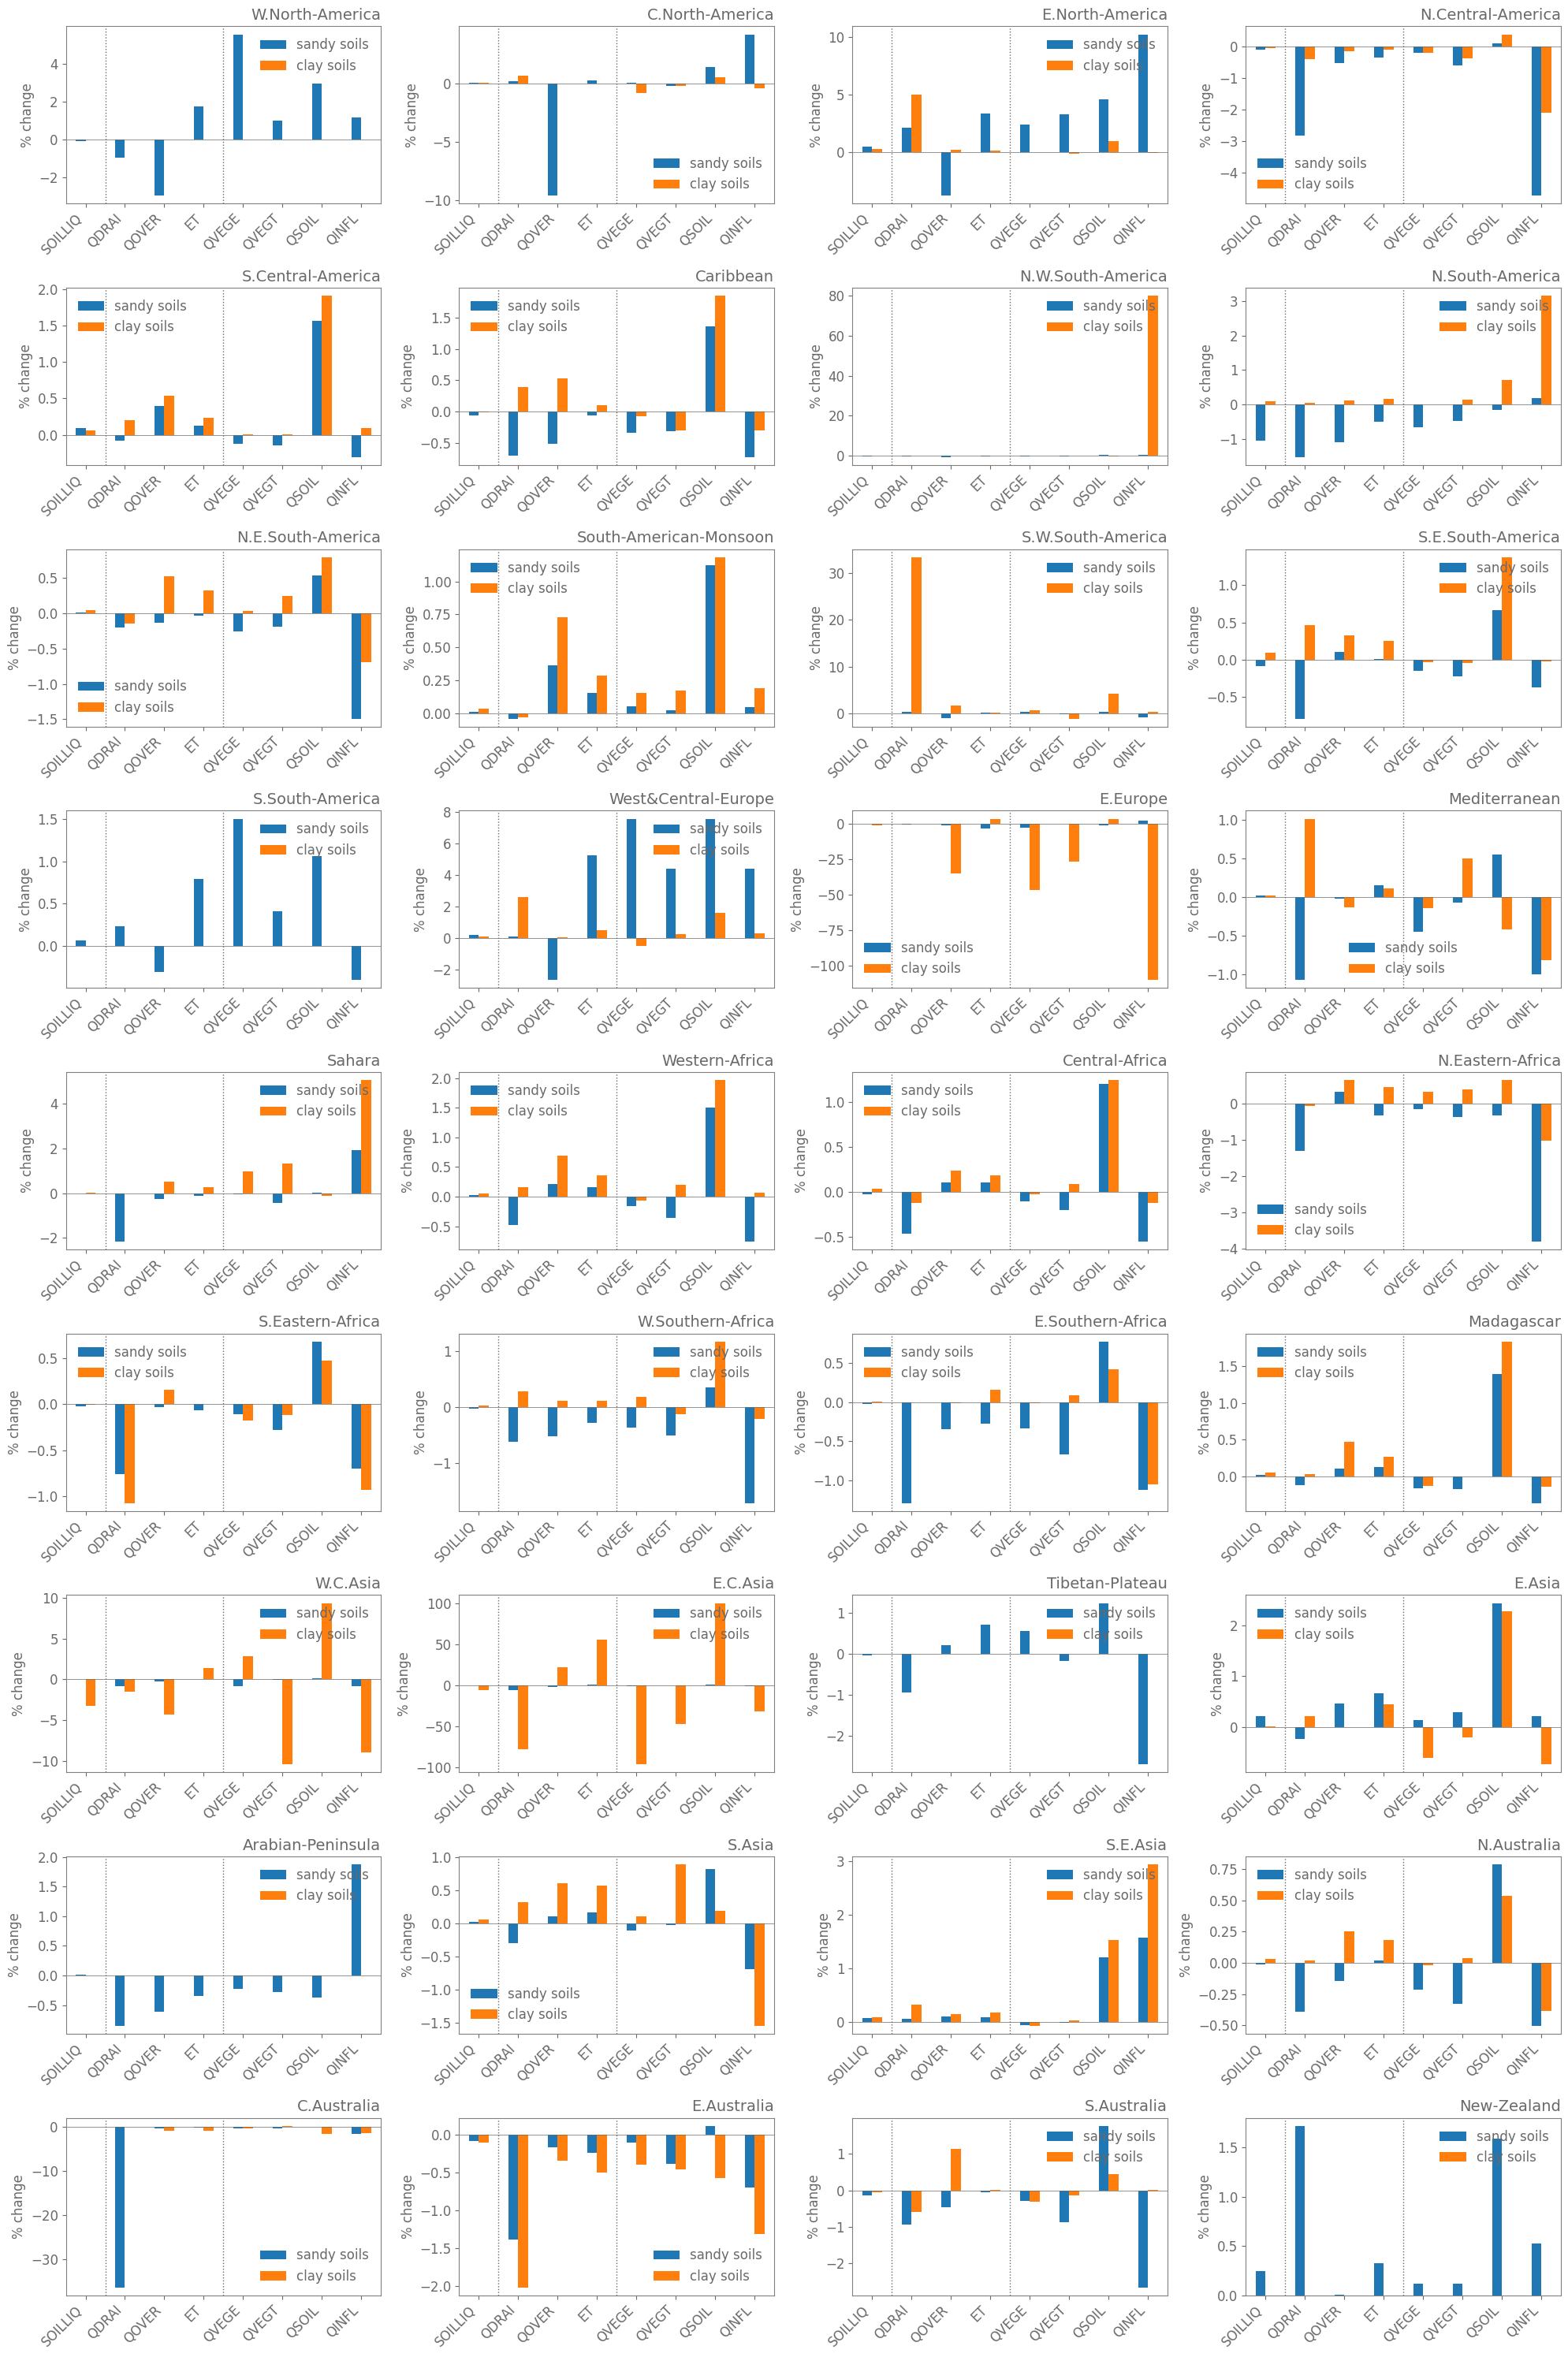

In [96]:
figsize = (20,30)


df_wbterms_sand = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'.PCT_SAND_drydays.nc', index_col=0)
df_wbterms_clay = pd.read_csv(procdir+'postprocessing/wbterm_delta_per_region_'+scenario+'.PCT_CLAY_drydays.nc', index_col=0)

region_ids_sand = list(map(int, df_wbterms_sand.loc[:, (df_wbterms_sand.notna().sum()>0)].keys().values))
region_ids_clay = list(map(int, df_wbterms_clay.loc[:, (df_wbterms_clay.notna().sum()>0)].keys().values))
ids_uniques = set(region_ids_clay + region_ids_sand )


fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

variables_wb = list(df_wbterms_sand.index)
x = np.arange(1,len(variables_wb)+1,1)

for i,region in enumerate(ids_uniques):
    
    
    df_wbterms_toplot = pd.DataFrame(df_wbterms_sand.loc[variables_wb_toplot, str(region)]).rename(columns={str(region):'sandy soils'})
    df_wbterms_toplot['clay soils'] = df_wbterms_clay.loc[variables_wb_toplot, str(region)]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    ax = axes[i]
    
    df_wbterms_toplot.plot.bar(ax=ax, legend=True)

    ax.set_title(region_name,loc='right')
    ax.axhline(y=0, color='dimgray', linewidth=0.5)
    ax.axvline(x=0.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.axvline(x=3.5, color='dimgray', linewidth=1, linestyle = 'dotted')
    ax.legend(frameon=False)
    ax.set_ylabel('% change')

    ax.set_xticks(range(0,len(variables_wb_toplot)),list(variables_wb_label), rotation=45, ha='right')

fig.tight_layout()